In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import natsort
import re 
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from keras import backend as K
from zipfile import ZipFile
import tensorflow as tf

Eerst moet de delay_dataset.zip worden geupload naar colab, zo kan het volgende blok code dit uitpakken

In [2]:
#Eerst delay_dataset uploaden naar google colab en wachten tot upload compleet is
standaarddirectory = os.getcwd()                  #standaarddirectory van google colab opslaan zodat we altijd terug kunnen keren naar deze
file_name = "delay_dataset.zip"                   #de naam van de zipfile met alle data
if not os.path.exists("stud_train"):              #Als de data nog niet uitgepakt is en deze folder dus nog niet bestaat, gaan we dit doen
  try:
    with ZipFile(file_name,'r') as zipper:
      zipper.extractall()
      print("extractie data klaar")
  except:
    sys.exit("Fout bij extractie data, zeker dat deze goed is geupload?")

if not os.path.exists("stud_train_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_ASDR")
if not os.path.exists("stud_train_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_GAUSS")
if not os.path.exists("stud_train_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_SBOX")

if not os.path.exists("stud_test_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_ASDR")
if not os.path.exists("stud_test_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_GAUSS")
if not os.path.exists("stud_test_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_SBOX")

extractie data klaar


In [3]:
# variable declaration
train_set = 'stud_train'  #een string voor de folder met de trainsamples
test_set = 'stud_test'    #een string voor de folder met de testsamples
delaypiekASDR = []    #arrays met werkelijke delays tussen de pieken (cijfers voor training en validatie)
delaypiekGAUSS = []
delaypiekSBOX = []
delaypiekASDRtest = []    #arrays met werkelijke delays tussen de pieken (cijfers voor testing)
delaypiekGAUSStest = []
delaypiekSBOXtest = []
grafieknummer = 0 #variabele voor grafieknummering

In [4]:
#Geeft een array met strings weer waarin de namen van de files in die map staan
def laadarraymetfilenamenuitmap(map):
    filenames = os.listdir(map)  # array met alle filenames van in folder
    filenames.sort()
    return filenames

In [5]:
#plot het signaal van een numpy array aan de hand van een megegeven signaalbestandsnaam
#Functie werd enkel gebruikt in het begin voor de twee verschillende signalen van 512 samples te visualiseren op 1 grafiek, niet meer nodig en niet meer gebruikt verder
def plotsignaal(signaal, evencheck, nummer, x = np.arange(0,512)): #signaal is naam bestand tussen aanhalingstekens
    if evencheck % 2 == 0:                                        #evencheck wordt gebruikt om elke keer twee signalen samen op 1 grafiek te zetten met elk een verschillend kleur
        kleur = "red"         #paar van signalen respectievelijk rood en blauw weergeven zodat het verschil duidelijk is
    else:
        kleur = "blue"
    plot = plt.figure(nummer)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.plot(x,np.load(signaal), color=kleur)

In [6]:
#Geeft de waarde van de positie van die piek terug aan de hand van de bestandsnaam
def geefpositiepiek(signaal):
  truncatedsignaal = (signaal.split("P_",1)[1]) #alles voor de xxx wegdoen dus BV ASDR0_P_ wegdoen
  piek = ''.join(x for x in truncatedsignaal[0:3] if x.isdigit()) #drie eerstvolgende karakters overlopen en als deze een cijfer is, maakt deze deel uit van de piek bv: 211_SNR20 wordt 211, 8_SNR26 wordt 8
  return piek

In [7]:
#voegt de array van twee signalen samen om 1 vector van 1024 samples te bekomen
def voegsamen(signaal1, signaal2):
  return np.concatenate([np.load(signaal1), np.load(signaal2)])

In [8]:
#wordt gebruikt om de lijst met de files te sorten op numerische orde ipv alfabetische orde om sortering van 0 1 10 11 ... 19 2 20 21 ... 29 3 30 31 etc te voorkomen maar 0 1 2 3 4 ... 99
#outsourced functies
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [9]:
#wordt gebruikt om de 200 signalen van 512 te combineren naar 100 van 1024
def combinedata(folder, dir, delayarray, typesignaal = "", testoftrain = "", aantalgrafiekenplotten = 0):
  nummer, evencheck = 1, 0
  for data in folder:
    evencheck += 1
    if evencheck % 2 == 0:     #controleert als we aan een even file zitten, zodat we deze kunnen samenvoegen met de oneven file die ervoor kwam
      os.chdir(f"stud_{testoftrain}")         #folder binnengaan waar we willen samenvoegen
      masterfile = voegsamen(previous, data) #masterfile is een array van 1024 nu
      os.chdir(standaarddirectory)
      os.chdir(dir)                         #folder binnengaan waar we willen saven
      savename = f"{nummer}{typesignaal}.npy"
      np.save(savename,masterfile)
      os.chdir(standaarddirectory)
      nummer += 1
      delayarray.append(512-int(geefpositiepiek(previous))+int(geefpositiepiek(data)))    #512-piek1+piek2 is waarde van delay

      #plotten voor eerste paar grafieken, mooie visualisatie als controle, wordt als default niet gedaan want variabele aantalgrafiekenplotten is 0
      if nummer <= aantalgrafiekenplotten:  #max 20 grafieken door memory limiet, dus aantalgrafiekenplotten niet groter dan 20 maken
        plot= plt.figure(nummer)
        plt.plot(np.arange(0, 1024),masterfile, color="red")

    previous = data

In [10]:
def plotpredictieerrors(predictionslist, delaypiek, titel = '', typesign = 'test'):
  global grafieknummer

  #x zorgt voor een juiste dimensionering van de x as in de grafiek
  if typesign == 'test':
    x = 100+1
  elif typesign == 'train':
    x = 90+1
  elif typesign == 'validation':
    x = 10+1
  elif typesign == 'totaltest':
    x = 3*100+1
  elif typesign == 'totaltrain':
    x = 3*90+1
  elif typesign == 'totalvalidation':
    x = 3*10+1

  error_list = []   #absolute waarde van de fout van predictie 
  for error1, error2 in zip(predictionslist, delaypiek):
    error_list.append(round(abs(error1 - error2)))

  y = (sum(error_list)/len(error_list)) #y waarde voor schaling y as grafiek
  print("De errors zijn (afgerond tot gehele waarden):")
  print(error_list)
  print("De predicties zijn:")
  print(predictionslist)
  print("De werkelijke waarden zijn:")
  print(delaypiek)

  #visualiseren error
  bar = plt.figure(grafieknummer)
  grafieknummer += 1
  plt.bar(np.arange(1, x), error_list)
  plt.ylim(0, y+25)
  plt.title(titel)
  plt.show()
  print() 

END OF FUNCTIONS

In [11]:
#main
#filenames inlezen
filenames = laadarraymetfilenamenuitmap(train_set)
filenamesASDR = filenames[0:200]
filenamesGAUSS = filenames[200:400]
filenamesSBOX = filenames[400:600]

filenamestest = laadarraymetfilenamenuitmap(test_set)
filenamesASDRtest = filenamestest[0:200]
filenamesGAUSStest = filenamestest[200:400]
filenamesSBOXtest = filenamestest[400:600]

#sorteren op numerische wijze ipv alfabetische wijze
filenamesASDR.sort(key=natural_keys)
filenamesGAUSS.sort(key=natural_keys)
filenamesSBOX.sort(key=natural_keys)
filenamesASDRtest.sort(key=natural_keys)
filenamesGAUSStest.sort(key=natural_keys)
filenamesSBOXtest.sort(key=natural_keys)

In [12]:
os.chdir(standaarddirectory)
#Nu gaan we de 6 folders opvullen waarin de files gecombineerd worden tot 100 signalen van 1024 samples
combinedata(filenamesASDR, "stud_train_combined_ASDR", delaypiekASDR, "ASDR", "train")
combinedata(filenamesGAUSS, "stud_train_combined_GAUSS", delaypiekGAUSS, "GAUSS", "train")
combinedata(filenamesSBOX, "stud_train_combined_SBOX", delaypiekSBOX, "SBOX", "train")

combinedata(filenamesASDRtest, "stud_test_combined_ASDR", delaypiekASDRtest, "ASDR", "test")
combinedata(filenamesGAUSStest, "stud_test_combined_GAUSS", delaypiekGAUSStest, "GAUSS", "test")
combinedata(filenamesSBOXtest, "stud_test_combined_SBOX", delaypiekSBOXtest, "SBOX", "test")

MODEL ADSR

In [13]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_ASDR")

#Traindata
#We gebruiken deze traindata om het NN te trainen
samplesASDR = [np.load(f"{x}ASDR.npy") for x in range(1, 91)]
samplesASDR = tf.convert_to_tensor(samplesASDR)

#Validatiedata
#We gebruiken de laatste 10% als validatiedata, deze data gebruiken we om de performantie van het NN te evalueren TIJDENS het trainen en zo de hyperparameters aan te passen. Het nn ziet validatiedata NIET op voorhand, in tegenstelling tot trainingsdata
samplesASDRvalidation = [np.load(f"{x}ASDR.npy") for x in range(91, 101)]
samplesASDRvalidation = tf.convert_to_tensor(samplesASDRvalidation)

os.chdir(standaarddirectory)

In [14]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_ASDR")

#Testdata
#We gebruiken deze testdata om het NN te evalueren
samplesASDRtest = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDRtest = tf.convert_to_tensor(samplesASDRtest)

os.chdir(standaarddirectory)

In [15]:
#TENSOR object maken voor y waarden NN training (de delaywaarden tussen de pieken)

#Traindata
delayASDR = pd.DataFrame(data = delaypiekASDR[0:90])
delayASDR = tf.convert_to_tensor(delayASDR)

#Validatiedata
delayASDRvalidation = pd.DataFrame(data = delaypiekASDR[90:])
delayASDRvalidation = tf.convert_to_tensor(delayASDRvalidation)

In [51]:
#Model aanmaken
modelASDR = tf.keras.Sequential()
modelASDR.add(layers.Dense(1024, activation='relu', input_shape=(1024,)))
modelASDR.add(layers.Dense(718, activation='relu'))
modelASDR.add(layers.Dense(512, activation='relu'))
modelASDR.add(layers.Dense(256, activation='relu'))
modelASDR.add(layers.Dense(128, activation='relu'))
modelASDR.add(layers.Dense(32, activation='relu'))
modelASDR.add(layers.Dense(1))

In [52]:
modelASDR.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_48 (Dense)            (None, 718)               735950    
                                                                 
 dense_49 (Dense)            (None, 512)               368128    
                                                                 
 dense_50 (Dense)            (None, 256)               131328    
                                                                 
 dense_51 (Dense)            (None, 128)               32896     
                                                                 
 dense_52 (Dense)            (None, 32)                4128      
                                                                 
 dense_53 (Dense)            (None, 1)                

In [53]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelASDR.compile(optimizer='Adam', loss='mse', metrics=['mse'])
K.set_value(modelASDR.optimizer.learning_rate, 0.0001)

In [54]:
#Model Trainen
history1 = modelASDR.fit(samplesASDR,
                        delayASDR,
                        epochs=500, #epochs is het aantal iteraties die we over de data doen
                        validation_data=(samplesASDRvalidation,delayASDRvalidation))

Epoch 1/500
3/3 [==============================] - 1s 265ms/step - loss: 332587.3750 - mse: 332587.3750 - val_loss: 327783.0312 - val_mse: 327783.0312
Epoch 2/500
3/3 [==============================] - 0s 42ms/step - loss: 332112.4062 - mse: 332112.4062 - val_loss: 327254.9375 - val_mse: 327254.9375
Epoch 3/500
3/3 [==============================] - 0s 47ms/step - loss: 331517.0625 - mse: 331517.0625 - val_loss: 326514.8125 - val_mse: 326514.8125
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 330676.9688 - mse: 330676.9688 - val_loss: 325454.0625 - val_mse: 325454.0625
Epoch 5/500
3/3 [==============================] - 0s 39ms/step - loss: 329463.7188 - mse: 329463.7188 - val_loss: 323909.6875 - val_mse: 323909.6875
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 327697.4062 - mse: 327697.4062 - val_loss: 321686.5938 - val_mse: 321686.5938
Epoch 7/500
3/3 [==============================] - 0s 35ms/step - loss: 325144.0938 - mse: 325144.0

In [55]:
predictionsASDR = modelASDR.predict(samplesASDRtest)
predictionsASDRtrain = modelASDR.predict(samplesASDR) #Ook eens testen op traindata voor controle
predictionsASDRval = modelASDR.predict(samplesASDRvalidation) #Ook eens testen op validatiedata voor controle

1/1 [==============================] - 0s 23ms/step


De errors zijn (afgerond tot gehele waarden):
[80, 12, 39, 2, 37, 75, 36, 24, 29, 65, 43, 34, 12, 175, 4, 101, 49, 81, 8, 2, 16, 107, 5, 87, 3, 59, 49, 79, 48, 12, 1, 61, 81, 16, 4, 31, 42, 42, 96, 189, 80, 8, 8, 15, 25, 1, 18, 7, 37, 8, 6, 28, 33, 36, 7, 20, 40, 20, 92, 11, 42, 50, 17, 63, 3, 27, 5, 95, 40, 18, 57, 55, 1, 188, 47, 26, 37, 5, 8, 35, 119, 43, 33, 33, 52, 22, 48, 26, 51, 38, 8, 41, 127, 179, 196, 11, 7, 59, 133, 15]
De predicties zijn:
[516.7254638671875, 618.0638427734375, 513.0756225585938, 600.8359375, 595.8406372070312, 484.7420654296875, 599.230712890625, 566.6949462890625, 589.4817504882812, 477.0693054199219, 568.1185302734375, 602.3883056640625, 582.6200561523438, 398.6650695800781, 560.523681640625, 642.9942016601562, 557.7645874023438, 466.0223388671875, 595.0582275390625, 574.1477661132812, 573.1807861328125, 491.8333435058594, 612.6536865234375, 511.0989990234375, 544.5585327148438, 488.4924011230469, 563.2850952148438, 644.1862182617188, 596.5055541992188, 5

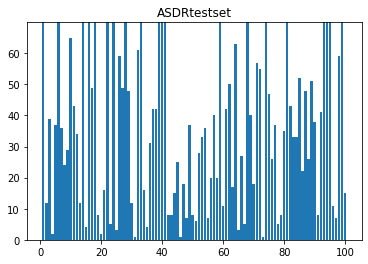


De errors zijn (afgerond tot gehele waarden):
[1, 0, 0, 0, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 8, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 1, 0, 0, 0, 8, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
De predicties zijn:
[572.3873901367188, 557.6094970703125, 587.7071533203125, 559.06298828125, 561.2627563476562, 609.587158203125, 605.650634765625, 564.3840942382812, 557.22265625, 578.003662109375, 605.0252075195312, 565.0830078125, 551.0272216796875, 566.1814575195312, 608.6443481445312, 599.6941528320312, 572.0980224609375, 576.8539428710938, 589.7570190429688, 568.5344848632812, 550.7765502929688, 566.04443359375, 583.783935546875, 589.6798095703125, 604.1373291015625, 546.6650390625, 605.9160766601562, 542.9573364257812, 556.6200561523438, 545.758544921875, 554.1796264648438, 557.7106323242188, 550.6595458984375, 598.7462768554688, 578.994140625, 599.2357788085938, 5

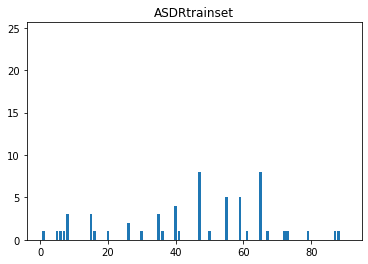


De errors zijn (afgerond tot gehele waarden):
[39, 54, 31, 24, 27, 36, 18, 79, 22, 31]
De predicties zijn:
[614.7997436523438, 552.243408203125, 510.5096435546875, 621.4698486328125, 600.1605834960938, 600.3240356445312, 581.7642822265625, 487.5714416503906, 553.18359375, 595.1369018554688]
De werkelijke waarden zijn:
[576, 606, 542, 597, 573, 564, 564, 567, 575, 564]


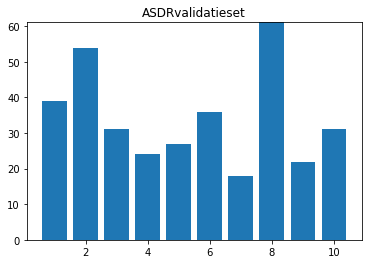

In [56]:
#Plotten van de errors op testdata
predictionslistASDR = predictionsASDR.tolist()  #converteren naar lijst
predictionslistASDRflat = [item for sublist in predictionslistASDR for item in sublist] #lijst plat maken
plotpredictieerrors(predictionslistASDRflat, delaypiekASDRtest, "ASDRtestset")

#plotten van de errors op traindata
predictionslistASDRtrain = predictionsASDRtrain.tolist()
predictionslistASDRtrainflat = [item for sublist in predictionslistASDRtrain for item in sublist] #lijst plat maken
plotpredictieerrors(predictionslistASDRtrainflat, delaypiekASDR[0:90], "ASDRtrainset", 'train')

#plotten van de errors op validatiedata
predictionslistASDRval = predictionsASDRval.tolist()
predictionslistASDRvalflat = [item for sublist in predictionslistASDRval for item in sublist] #lijst plat maken

plotpredictieerrors(predictionslistASDRvalflat, delaypiekASDR[90:], "ASDRvalidatieset", 'validation')

GAUSS MODEL

In [ ]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_GAUSS")

#Traindata
#We gebruiken deze traindata om het NN te trainen
samplesGAUSS = [np.load(f"{x}GAUSS.npy") for x in range(1, 91)]
samplesGAUSS = tf.convert_to_tensor(samplesGAUSS)

#Validatiedata
#We gebruiken de laatste 10% als validatiedata, deze data gebruiken we om de performantie van het NN te evalueren TIJDENS het trainen en zo de hyperparameters aan te passen. Het nn ziet validatiedata NIET op voorhand, in tegenstelling tot trainingsdata
samplesGAUSSvalidation = [np.load(f"{x}GAUSS.npy") for x in range(91, 101)]
samplesGAUSSvalidation = tf.convert_to_tensor(samplesGAUSSvalidation)

os.chdir(standaarddirectory)

In [ ]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_GAUSS")

samplesGAUSStest = [np.load(f"{x}GAUSS.npy") for x in range(1, 101)]
samplesGAUSStest = tf.convert_to_tensor(samplesGAUSStest)

os.chdir(standaarddirectory)

In [ ]:
#TENSOR object maken voor y waarden NN training (de delaywaarden tussen de pieken)

#Traindata
delayGAUSS = pd.DataFrame(data = delaypiekGAUSS[0:90])
delayGAUSS = tf.convert_to_tensor(delayGAUSS)

#Validatiedata
delayGAUSSvalidation = pd.DataFrame(data = delaypiekGAUSS[90:])
delayGAUSSvalidation = tf.convert_to_tensor(delayGAUSSvalidation)

In [ ]:
#Model aanmaken
modelGAUSS = tf.keras.Sequential()
modelGAUSS.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelGAUSS.add(layers.Dense(256, activation='relu'))
modelGAUSS.add(layers.Dense(64, activation='relu'))
modelGAUSS.add(layers.Dense(1))

In [ ]:
modelGAUSS.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 672,641
Trainable params: 672,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelGAUSS.compile(optimizer='adam', loss='mse', metrics=['mse'])
K.set_value(modelGAUSS.optimizer.learning_rate, 0.0001)

In [ ]:
#Model Trainen
history2 = modelGAUSS.fit(samplesGAUSS,
                        delayGAUSS,
                        epochs=2000,
                        validation_data=(samplesGAUSSvalidation,delayGAUSSvalidation))

Epoch 1/2000
3/3 [==============================] - 1s 102ms/step - loss: 124.5947 - mse: 124.5947 - val_loss: 494.5926 - val_mse: 494.5926
Epoch 2/2000
3/3 [==============================] - 0s 21ms/step - loss: 152.7523 - mse: 152.7523 - val_loss: 584.9847 - val_mse: 584.9847
Epoch 3/2000
3/3 [==============================] - 0s 21ms/step - loss: 87.1669 - mse: 87.1669 - val_loss: 890.1058 - val_mse: 890.1058
Epoch 4/2000
3/3 [==============================] - 0s 23ms/step - loss: 84.2401 - mse: 84.2401 - val_loss: 558.4608 - val_mse: 558.4608
Epoch 5/2000
3/3 [==============================] - 0s 22ms/step - loss: 57.4440 - mse: 57.4440 - val_loss: 512.9553 - val_mse: 512.9553
Epoch 6/2000
3/3 [==============================] - 0s 19ms/step - loss: 51.6750 - mse: 51.6750 - val_loss: 687.2550 - val_mse: 687.2550
Epoch 7/2000
3/3 [==============================] - 0s 18ms/step - loss: 48.9640 - mse: 48.9640 - val_loss: 760.7208 - val_mse: 760.7208
Epoch 8/2000
3/3 [==================

In [ ]:
predictionsGAUSS = modelGAUSS.predict(samplesGAUSStest)
predictionsGAUSStrain = modelGAUSS.predict(samplesGAUSS) #Ook eens testen op traindata voor controle
predictionsGAUSSval = modelGAUSS.predict(samplesGAUSSvalidation) #Ook eens testen op validatiedata voor controle

1/1 [==============================] - 0s 16ms/step


De errors zijn (afgerond tot gehele waarden):
[2, 1, 4, 2, 1, 2, 2, 4, 1, 3, 0, 10, 3, 1, 1, 6, 7, 3, 0, 2, 1, 3, 1, 4, 5, 3, 2, 4, 5, 3, 8, 7, 1, 2, 1, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 4, 1, 103, 825, 1, 1, 4, 2, 4, 150, 2, 3, 2, 2, 4, 2, 24, 1, 8, 0, 5, 3, 5, 1, 160, 1, 2, 53, 3, 7, 2, 5, 2, 0, 1, 6, 6, 0, 2, 1, 6, 2, 1, 5, 0, 1, 3, 1, 2, 2, 6, 1, 7, 0, 0]
De predicties zijn:
[553.6434936523438, 589.74365234375, 557.3161010742188, 601.8157348632812, 555.1796875, 557.5730590820312, 598.8003540039062, 557.755615234375, 610.4717407226562, 588.5606689453125, 578.8265380859375, 565.0501098632812, 586.1843872070312, 606.179931640625, 604.26904296875, 582.1498413085938, 594.0584106445312, 551.4671020507812, 555.3881225585938, 610.5521240234375, 605.1821899414062, 607.8240356445312, 564.1076049804688, 562.9666748046875, 563.4561157226562, 550.0420532226562, 599.2485961914062, 601.9763793945312, 612.1896362304688, 557.8607788085938, 552.653076171875, 573.1055297851562, 604.9061889648438, 557.077

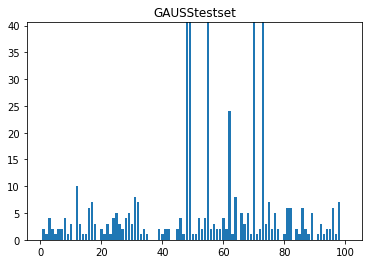


De errors zijn (afgerond tot gehele waarden):
[0, 1, 2, 1, 3, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 4, 1, 0, 0, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]
De predicties zijn:
[543.3936157226562, 583.755126953125, 555.7276611328125, 559.8897705078125, 591.9218139648438, 589.7927856445312, 588.6926879882812, 590.4153442382812, 586.4866943359375, 546.4255981445312, 570.9395141601562, 566.080078125, 605.3034057617188, 603.0908203125, 569.04150390625, 593.330078125, 594.2982788085938, 604.7727661132812, 556.1741333007812, 611.0812377929688, 586.4273681640625, 543.2227172851562, 594.8530883789062, 542.9037475585938, 569.2653198242188, 586.845703125, 556.3700561523438, 608.39501953125, 550.2109985351562, 550.1386108398438, 568.7427368164062, 607.0534057617188, 572.0234985351562, 546.6384887695312, 593.5747680664062, 583.283203125, 6

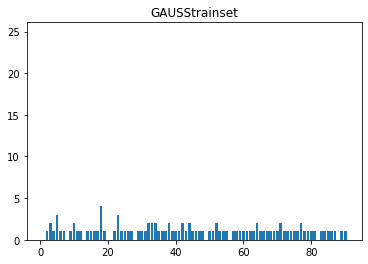


De errors zijn (afgerond tot gehele waarden):
[51, 0, 84, 3, 0, 3, 3, 1, 1, 3]
De predicties zijn:
[631.9735717773438, 548.3214721679688, 676.6564331054688, 593.2423706054688, 583.1990356445312, 606.5687866210938, 579.1763305664062, 574.9517822265625, 596.7420043945312, 553.3384399414062]
De werkelijke waarden zijn:
[581, 548, 593, 596, 583, 604, 576, 574, 596, 550]


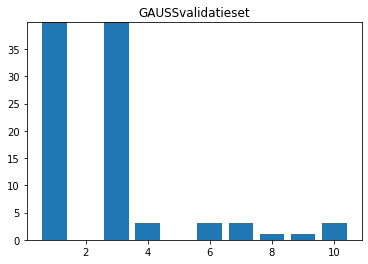

In [ ]:
#Plotten van de errors op testdata
predictionslistGAUSS = predictionsGAUSS.tolist()  #converteren naar lijst
predictionslistGAUSSflat = [item for sublist in predictionslistGAUSS for item in sublist] #lijst plat maken
plotpredictieerrors(predictionslistGAUSSflat, delaypiekGAUSStest, "GAUSStestset")

#plotten van de errors op traindata
predictionslistGAUSStrain = predictionsGAUSStrain.tolist()
predictionslistGAUSStrainflat = [item for sublist in predictionslistGAUSStrain for item in sublist] #lijst plat maken
plotpredictieerrors(predictionslistGAUSStrainflat, delaypiekGAUSS[0:90], "GAUSStrainset", 'train')

#plotten van de errors op validatiedata
predictionslistGAUSSval = predictionsGAUSSval.tolist()
predictionslistGAUSSvalflat = [item for sublist in predictionslistGAUSSval for item in sublist] #lijst plat maken

plotpredictieerrors(predictionslistGAUSSvalflat, delaypiekGAUSS[90:], "GAUSSvalidatieset", 'validation')

SBOX MODEL

In [ ]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_SBOX")

#Traindata
#We gebruiken deze traindata om het NN te trainen
samplesSBOX = [np.load(f"{x}SBOX.npy") for x in range(1, 91)]
samplesSBOX = tf.convert_to_tensor(samplesSBOX)

#Validatiedata
#We gebruiken de laatste 10% als validatiedata, deze data gebruiken we om de performantie van het NN te evalueren TIJDENS het trainen en zo de hyperparameters aan te passen. Het nn ziet validatiedata NIET op voorhand, in tegenstelling tot trainingsdata
samplesSBOXvalidation = [np.load(f"{x}SBOX.npy") for x in range(91, 101)]
samplesSBOXvalidation = tf.convert_to_tensor(samplesSBOXvalidation)

os.chdir(standaarddirectory)

In [ ]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_SBOX")

samplesSBOXtest = [np.load(f"{x}SBOX.npy") for x in range(1, 101)]
samplesSBOXtest = tf.convert_to_tensor(samplesSBOXtest)

os.chdir(standaarddirectory)


In [ ]:
#TENSOR object maken voor y waarden NN training (de delaywaarden tussen de pieken)

#Traindata
delaySBOX = pd.DataFrame(data = delaypiekSBOX[0:90])
delaySBOX = tf.convert_to_tensor(delaySBOX)

#Validatiedata
delaySBOXvalidation = pd.DataFrame(data = delaypiekSBOX[90:])
delaySBOXvalidation = tf.convert_to_tensor(delaySBOXvalidation)

In [ ]:
#Model aanmaken
modelSBOX = tf.keras.Sequential()
modelSBOX.add(layers.Dense(1024, activation='relu', input_shape=(1024,)))
modelSBOX.add(layers.Dense(512, activation='relu'))
modelSBOX.add(layers.Dense(128, activation='relu'))
modelSBOX.add(layers.Dense(32, activation='relu'))
modelSBOX.add(layers.Dense(1))

In [ ]:
modelSBOX.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dense_16 (Dense)            (None, 128)               65664     
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,644,225
Trainable params: 1,644,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelSBOX.compile(optimizer='adam', loss='mae', metrics=['mae'])
K.set_value(modelSBOX.optimizer.learning_rate, 0.0001)

In [ ]:
#Model Trainen
history3 = modelSBOX.fit(samplesSBOX,
                        delaySBOX,
                        epochs=5000,
                        validation_data=(samplesSBOXvalidation,delaySBOXvalidation))

Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 34ms/step - loss: 4.2536 - mae: 4.2536 - val_loss: 6.0955 - val_mae: 6.0955
Epoch 2502/5000
3/3 [==============================] - 0s 32ms/step - loss: 3.8787 - mae: 3.8787 - val_loss: 6.1997 - val_mae: 6.1997
Epoch 2503/5000
3/3 [==============================] - 0s 32ms/step - loss: 3.4119 - mae: 3.4119 - val_loss: 9.0359 - val_mae: 9.0359
Epoch 2504/5000
3/3 [==============================] - 0s 32ms/step - loss: 3.5639 - mae: 3.5639 - val_loss: 8.8283 - val_mae: 8.8283
Epoch 2505/5000
3/3 [==============================] - 0s 33ms/step - loss: 3.7278 - mae: 3.7278 - val_loss: 6.4712 - val_mae: 6.4712
Epoch 2506/5000
3/3 [==============================] - 0s 41ms/step - loss: 4.1583 - mae: 4.1583 - val_loss: 6.1305 - val_mae: 6.1305
Epoch 2507/5000
3/3 [==============================] - 0s 32ms/step - loss: 3.7871 - mae: 3.7871 - val_loss: 9.5363 - val_mae: 9.5363
Epoch 2508/5000
3/3 [======

In [ ]:
predictionsSBOX = modelSBOX.predict(samplesSBOXtest)
predictionsSBOXtrain = modelSBOX.predict(samplesSBOX) #Ook eens testen op traindata voor controle
predictionsSBOXval = modelSBOX.predict(samplesSBOXvalidation) #Ook eens testen op validatiedata voor controle

1/1 [==============================] - 0s 22ms/step


De errors zijn (afgerond tot gehele waarden):
[32, 2, 4, 8, 24, 3, 20, 29, 16, 32, 7, 10, 8, 5, 17, 15, 10, 20, 12, 15, 25, 13, 1, 14, 28, 3, 0, 15, 42, 11, 35, 24, 4, 22, 6, 17, 21, 0, 8, 17, 13, 16, 5, 2, 6, 13, 8, 27, 10, 5, 14, 2, 26, 17, 12, 16, 23, 10, 6, 8, 6, 12, 1, 11, 26, 3, 16, 5, 11, 11, 8, 17, 1, 7, 4, 16, 17, 30, 4, 9, 5, 18, 2, 14, 6, 4, 30, 0, 16, 11, 12, 30, 22, 13, 14, 12, 14, 23, 25, 11]
De predicties zijn:
[550.5781860351562, 543.475341796875, 590.434814453125, 539.9598999023438, 536.1354370117188, 545.9891357421875, 552.65283203125, 527.3228149414062, 542.4910278320312, 550.6314086914062, 578.9931030273438, 576.7652587890625, 566.0345458984375, 561.6365356445312, 574.258056640625, 580.8670043945312, 532.45654296875, 555.3660888671875, 546.1502075195312, 533.83544921875, 582.7147827148438, 538.7694091796875, 551.1524047851562, 530.4343872070312, 540.119384765625, 544.2282104492188, 595.0734252929688, 565.1881103515625, 568.256591796875, 552.7578735351562, 577.778747

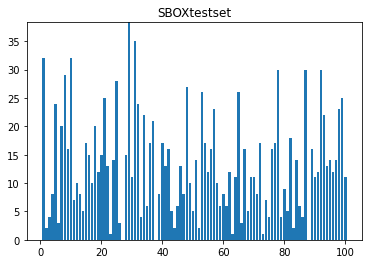


De errors zijn (afgerond tot gehele waarden):
[9, 11, 10, 9, 9, 10, 9, 10, 9, 11, 9, 11, 9, 9, 10, 9, 9, 8, 9, 10, 8, 9, 9, 10, 10, 9, 9, 11, 11, 8, 9, 10, 8, 9, 10, 11, 9, 10, 9, 8, 9, 8, 8, 10, 11, 8, 9, 9, 9, 8, 8, 10, 10, 10, 9, 9, 9, 9, 11, 9, 12, 8, 9, 8, 9, 10, 10, 11, 9, 8, 10, 11, 9, 7, 9, 8, 10, 9, 10, 10, 8, 11, 10, 9, 13, 8, 7, 9, 10, 9]
De predicties zijn:
[584.632080078125, 579.369384765625, 591.131103515625, 571.5805053710938, 542.4517211914062, 566.8377075195312, 565.8703002929688, 582.141845703125, 582.9256591796875, 569.48583984375, 546.2210083007812, 599.8604736328125, 548.4902954101562, 577.9890747070312, 551.834228515625, 544.2689819335938, 532.7164916992188, 569.7105102539062, 576.2994384765625, 561.2095336914062, 598.7189331054688, 563.48974609375, 584.6106567382812, 584.4693603515625, 583.2060546875, 536.43994140625, 571.0440673828125, 599.1653442382812, 592.776123046875, 598.7301635742188, 563.3226318359375, 600.2088623046875, 577.9224243164062, 552.6505737304

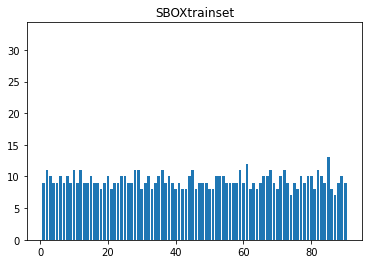


De errors zijn (afgerond tot gehele waarden):
[6, 10, 11, 21, 12, 8, 31, 22, 6, 15]
De predicties zijn:
[563.6829223632812, 594.9548950195312, 565.0861206054688, 586.9559936523438, 585.8302612304688, 575.9659423828125, 561.8687744140625, 523.4189453125, 598.4008178710938, 592.6309204101562]
De werkelijke waarden zijn:
[570, 605, 576, 608, 598, 584, 593, 545, 604, 608]


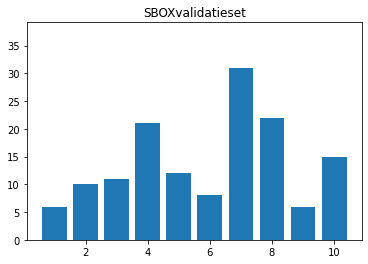

In [ ]:
#Plotten van de errors op testdata
predictionslistSBOX = predictionsSBOX.tolist()  #converteren naar lijst
predictionslistSBOXflat = [item for sublist in predictionslistSBOX for item in sublist] #lijst plat maken
plotpredictieerrors(predictionslistSBOXflat, delaypiekSBOXtest, "SBOXtestset")

#plotten van de errors op traindata
predictionslistSBOXtrain = predictionsSBOXtrain.tolist()
predictionslistSBOXtrainflat = [item for sublist in predictionslistSBOXtrain for item in sublist] #lijst plat maken
plotpredictieerrors(predictionslistSBOXtrainflat, delaypiekSBOX[0:90], "SBOXtrainset", 'train')

#plotten van de errors op validatiedata
predictionslistSBOXval = predictionsSBOXval.tolist()
predictionslistSBOXvalflat = [item for sublist in predictionslistSBOXval for item in sublist] #lijst plat maken

plotpredictieerrors(predictionslistSBOXvalflat, delaypiekSBOX[90:], "SBOXvalidatieset", 'validation')

MODEL VOOR ALLE DRIE DE SIGNALEN

In [ ]:
#TENSOR VAN 300X1024
samplestotal = tf.concat([samplesASDR, tf.concat([samplesGAUSS, samplesSBOX], axis=0)], axis=0)
samplestotalvalidation = tf.concat([samplesASDRvalidation, tf.concat([samplesGAUSSvalidation, samplesSBOXvalidation], axis=0)], axis=0)
samplestotaltest = tf.concat([samplesASDRtest, tf.concat([samplesGAUSStest, samplesSBOXtest], axis=0)], axis=0)

delaytotal = tf.concat([delayASDR, tf.concat([delayGAUSS, delaySBOX], axis=0)], axis=0)
delaytotalvalidation = tf.concat([delayASDRvalidation, tf.concat([delayGAUSSvalidation, delaySBOXvalidation], axis=0)], axis=0)

In [ ]:
#Model aanmaken
modeltotal = tf.keras.Sequential()
modeltotal.add(layers.Dense(512, activation='linear', input_shape=(1024,)))
modeltotal.add(layers.Dense(256, activation='linear'))
modeltotal.add(layers.Dense(64, activation='linear'))
modeltotal.add(layers.Dense(8, activation='linear'))
modeltotal.add(layers.Dense(1))

In [ ]:
modeltotal.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_101 (Dense)           (None, 512)               524800    
                                                                 
 dense_102 (Dense)           (None, 256)               131328    
                                                                 
 dense_103 (Dense)           (None, 64)                16448     
                                                                 
 dense_104 (Dense)           (None, 8)                 520       
                                                                 
 dense_105 (Dense)           (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modeltotal.compile(optimizer='Adam', loss='mse', metrics=['mse'])
K.set_value(modeltotal.optimizer.learning_rate, 0.0001)

In [ ]:
#Model Trainen
history4 = modeltotal.fit(samplestotal,
                        delaytotal,
                        epochs=2000,
                        validation_data=(samplestotalvalidation,delaytotalvalidation))

Epoch 1/2000
9/9 [==============================] - 1s 35ms/step - loss: 322484.3750 - mse: 322484.3750 - val_loss: 305766.0000 - val_mse: 305766.0000
Epoch 2/2000
9/9 [==============================] - 0s 15ms/step - loss: 286349.7188 - mse: 286349.7188 - val_loss: 267680.0312 - val_mse: 267680.0312
Epoch 3/2000
9/9 [==============================] - 0s 13ms/step - loss: 243605.0156 - mse: 243605.0156 - val_loss: 218874.5469 - val_mse: 218874.5469
Epoch 4/2000
9/9 [==============================] - 0s 13ms/step - loss: 191229.4688 - mse: 191229.4688 - val_loss: 164152.7656 - val_mse: 164152.7656
Epoch 5/2000
9/9 [==============================] - 0s 14ms/step - loss: 140819.4062 - mse: 140819.4062 - val_loss: 121414.4141 - val_mse: 121414.4141
Epoch 6/2000
9/9 [==============================] - 0s 13ms/step - loss: 113818.0547 - mse: 113818.0547 - val_loss: 112355.0312 - val_mse: 112355.0312
Epoch 7/2000
9/9 [==============================] - 0s 13ms/step - loss: 115467.7188 - mse: 11

In [ ]:
predictionstotal = modeltotal.predict(samplestotaltest)
predictionstotaltrain = modeltotal.predict(samplestotal) #Ook eens testen op traindata voor controle
predictionstotalval = modeltotal.predict(samplestotalvalidation) #Ook eens testen op validatiedata voor controle

1/1 [==============================] - 0s 25ms/step


De errors zijn (afgerond tot gehele waarden):
[49, 155, 6, 9, 22, 9, 39, 17, 11, 2, 92, 46, 17, 49, 0, 3, 21, 7, 10, 23, 95, 65, 64, 98, 15, 3, 70, 19, 2, 9, 35, 1, 7, 35, 15, 57, 30, 23, 30, 109, 148, 0, 7, 47, 12, 61, 27, 25, 1, 16, 1, 41, 59, 9, 31, 22, 4, 6, 23, 31, 29, 14, 9, 32, 50, 46, 8, 102, 3, 32, 20, 46, 32, 40, 29, 89, 20, 28, 46, 3, 43, 2, 32, 41, 66, 1, 3, 32, 90, 1, 1, 66, 21, 68, 51, 44, 27, 179, 76, 16, 79, 48, 31, 14, 40, 6, 45, 17, 17, 22, 28, 3, 83, 17, 124, 566, 202, 81, 30, 37, 24, 70, 21, 4, 99, 44, 148, 25, 109, 87, 104, 93, 45, 194, 23, 84, 83, 128, 57, 5, 108, 21, 46, 32, 57, 18, 120, 1388, 946, 177, 9, 13, 77, 126, 36, 98, 64, 108, 286, 20, 33, 175, 93, 99, 2, 153, 9, 39, 36, 589, 66, 59, 630, 1, 275, 26, 133, 67, 34, 63, 83, 46, 29, 145, 23, 31, 87, 54, 32, 75, 17, 26, 32, 24, 104, 416, 4, 75, 40, 114, 62, 16, 12, 5, 3, 50, 29, 32, 49, 50, 1, 64, 79, 71, 17, 33, 14, 28, 0, 16, 23, 15, 9, 7, 59, 36, 2, 7, 62, 20, 15, 22, 6, 10, 21, 4, 41, 42, 2, 19, 19, 1, 11

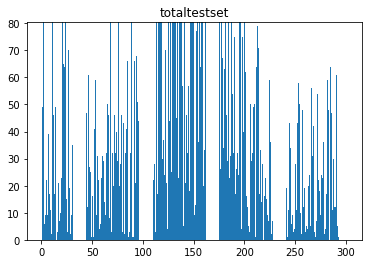

De errors zijn (afgerond tot gehele waarden):
[3, 1, 17, 11, 1, 5, 10, 5, 9, 8, 1, 10, 4, 7, 39, 14, 15, 6, 3, 9, 5, 29, 1, 5, 11, 12, 0, 3, 2, 10, 20, 5, 8, 3, 3, 9, 19, 1, 3, 0, 5, 15, 5, 19, 14, 11, 3, 3, 14, 3, 0, 10, 9, 2, 27, 3, 2, 2, 15, 13, 13, 23, 12, 6, 12, 0, 6, 3, 3, 6, 3, 13, 10, 2, 7, 11, 1, 4, 3, 4, 9, 6, 10, 1, 1, 1, 3, 22, 6, 3, 8, 2, 52, 3, 10, 4, 11, 4, 1, 1, 21, 3, 16, 53, 5, 2, 52, 44, 3, 13, 19, 24, 7, 70, 13, 17, 4, 1, 7, 13, 9, 24, 9, 12, 8, 39, 8, 15, 17, 22, 25, 3, 24, 27, 0, 2, 40, 4, 5, 11, 62, 12, 19, 29, 5, 5, 1, 35, 3, 16, 2, 10, 32, 13, 42, 3, 12, 11, 16, 37, 11, 3, 2, 9, 2, 21, 65, 7, 2, 2, 2, 76, 6, 0, 33, 3, 7, 10, 23, 5, 1, 8, 6, 10, 8, 5, 13, 7, 5, 13, 13, 9, 15, 3, 13, 12, 19, 1, 12, 11, 5, 1, 2, 16, 3, 15, 10, 14, 11, 4, 8, 5, 4, 13, 2, 7, 6, 3, 7, 16, 0, 10, 8, 7, 7, 6, 4, 5, 7, 8, 5, 6, 7, 2, 5, 17, 2, 7, 3, 13, 3, 14, 6, 11, 5, 7, 2, 3, 10, 2, 3, 8, 5, 10, 6, 6, 6, 12, 12, 2, 2, 5, 1, 0, 2, 6, 5, 2, 4, 6]
De predicties zijn:
[575.92529296875, 5

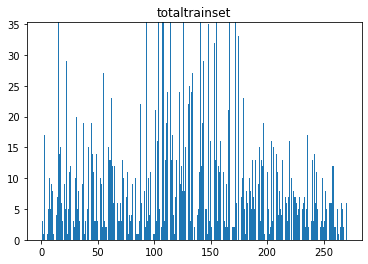

De errors zijn (afgerond tot gehele waarden):
[13, 34, 0, 7, 22, 10, 31, 21, 8, 86, 884, 20, 681, 193, 19, 8, 86, 19, 77, 14, 41, 5, 9, 31, 36, 21, 22, 67, 28, 76]
De predicties zijn:
[562.5697631835938, 572.3275756835938, 541.85546875, 589.8698120117188, 595.4850463867188, 574.0294799804688, 532.7826538085938, 545.7796020507812, 566.9262084960938, 478.1114807128906, -302.9637756347656, 528.4954833984375, 1273.9931640625, 403.1175537109375, 563.7951049804688, 596.0269165039062, 662.2595825195312, 593.1430053710938, 518.7959594726562, 536.2388916015625, 611.4208374023438, 600.3374633789062, 584.79833984375, 577.2933349609375, 561.7282104492188, 563.0221557617188, 614.6292114257812, 612.2711791992188, 575.8329467773438, 531.7728881835938]
De werkelijke waarden zijn:
[576, 606, 542, 597, 573, 564, 564, 567, 575, 564, 581, 548, 593, 596, 583, 604, 576, 574, 596, 550, 570, 605, 576, 608, 598, 584, 593, 545, 604, 608]


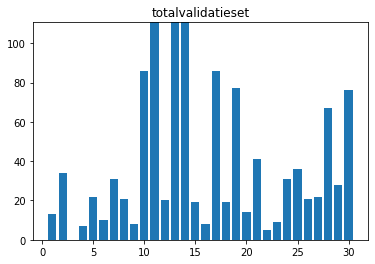

In [ ]:
#Plotten van de errors op testdata
predictionslisttotal = predictionstotal.tolist()  #converteren naar lijst
predictionslisttotalflat = [item for sublist in predictionslisttotal for item in sublist] #lijst plat maken

delaypiektotaltest = delaypiekASDRtest + delaypiekGAUSStest + delaypiekSBOXtest
plotpredictieerrors(predictionslisttotalflat, delaypiektotaltest, "totaltestset", "totaltest")


#plotten van de errors op traindata
predictionslisttotaltrain = predictionstotaltrain.tolist()
predictionslisttotaltrainflat = [item for sublist in predictionslisttotaltrain for item in sublist] #lijst plat maken

delaytotal = delaypiekASDR[0:90] + delaypiekGAUSS[0:90] + delaypiekSBOX[0:90]
plotpredictieerrors(predictionslisttotaltrainflat, delaytotal, "totaltrainset", 'totaltrain')


#plotten van de errors op validatiedata
predictionslisttotalval = predictionstotalval.tolist()
predictionslisttotalvalflat = [item for sublist in predictionslisttotalval for item in sublist] #lijst plat maken

delaytotalvalidation = delaypiekASDR[90:] + delaypiekGAUSS[90:] + delaypiekSBOX[90:]

plotpredictieerrors(predictionslisttotalvalflat, delaytotalvalidation, "totalvalidatieset", 'totalvalidation')



In [ ]:
#Testen ASDR model op GAUSS en SBOX
predictionsGAUSS_ASDR = modelASDR.predict(samplesGAUSStest)
predictionslistGAUSS_ASDR = predictionsGAUSS_ASDR.tolist()  #converteren naar lijst
predictionslistGAUSS_ASDRflat = [item for sublist in predictionslistGAUSS_ASDR for item in sublist] #lijst plat maken

predictionsSBOX_ASDR = modelASDR.predict(samplesSBOXtest)
predictionslistSBOX_ASDR = predictionsSBOX_ASDR.tolist()  #converteren naar lijst
predictionslistSBOX_ASDRflat = [item for sublist in predictionslistSBOX_ASDR for item in sublist] #lijst plat maken

#Testen GAUSS model op ASDR EN SBOX
predictionsASDR_GAUSS = modelGAUSS.predict(samplesASDRtest)
predictionslistASDR_GAUSS = predictionsASDR_GAUSS.tolist()  #converteren naar lijst
predictionslistASDR_GAUSSflat = [item for sublist in predictionslistASDR_GAUSS for item in sublist] #lijst plat maken

predictionsSBOX_GAUSS = modelGAUSS.predict(samplesSBOXtest)
predictionslistSBOX_GAUSS = predictionsSBOX_GAUSS.tolist()  #converteren naar lijst
predictionslistSBOX_GAUSSflat = [item for sublist in predictionslistSBOX_GAUSS for item in sublist] #lijst plat maken

#Testen SBOX model op ASDR EN GAUSS
predictionsASDR_SBOX = modelSBOX.predict(samplesASDRtest)
predictionslistASDR_SBOX = predictionsASDR_SBOX.tolist()  #converteren naar lijst
predictionslistASDR_SBOXflat = [item for sublist in predictionslistASDR_SBOX for item in sublist] #lijst plat maken

predictionsGAUSS_SBOX = modelSBOX.predict(samplesGAUSStest)
predictionslistGAUSS_SBOX = predictionsGAUSS_SBOX.tolist()  #converteren naar lijst
predictionslistGAUSS_SBOXflat = [item for sublist in predictionslistGAUSS_SBOX for item in sublist] #lijst plat maken


4/4 [==============================] - 0s 4ms/step


De errors zijn (afgerond tot gehele waarden):
[3085, 3161, 1556, 3172, 3007, 3057, 2662, 2918, 4422, 2661, 3019, 2788, 2208, 2650, 3105, 5930, 4439, 2923, 3100, 3352, 2618, 2647, 3016, 2909, 3081, 2231, 3204, 1636, 2920, 2440, 3429, 2720, 2913, 2290, 3312, 3470, 2250, 4890, 2919, 2153, 2303, 2903, 3418, 1812, 2654, 3021, 2953, 1879, 16163, 1591, 2736, 2869, 2646, 265, 8354, 3242, 3050, 3366, 1574, 2470, 2583, 6886, 2708, 294, 2888, 3080, 2194, 2431, 2287, 6414, 3406, 2962, 8633, 2923, 2571, 2488, 3117, 2805, 1513, 2856, 2892, 1375, 3474, 1975, 2406, 2765, 2748, 2876, 2957, 1949, 2424, 3083, 2918, 3127, 2544, 10573, 2927, 2171, 2892, 2761]
De predicties zijn:
[3637.336181640625, 3749.805908203125, 2109.16455078125, 3776.4423828125, 3561.411376953125, 3613.37255859375, 3258.763427734375, 3472.060302734375, 5033.26513671875, 3247.241943359375, 3597.9853515625, 3363.19287109375, 2797.029296875, 3254.94580078125, 3709.66259765625, 6517.73779296875, 5026.3720703125, 3471.393798828125, 3655.3

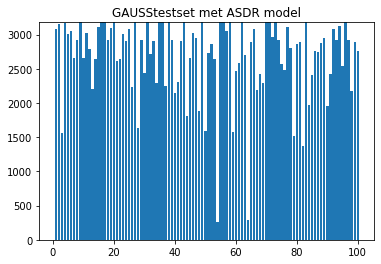

De errors zijn (afgerond tot gehele waarden):
[902, 918, 593, 520, 1005, 979, 974, 991, 788, 506, 953, 882, 863, 992, 407, 670, 819, 512, 925, 708, 683, 1075, 678, 653, 802, 1026, 984, 802, 547, 414, 604, 336, 1061, 389, 508, 901, 792, 780, 745, 793, 871, 789, 871, 817, 736, 794, 872, 670, 822, 1019, 456, 760, 484, 1014, 847, 366, 1009, 876, 395, 897, 736, 736, 716, 904, 405, 678, 650, 870, 914, 821, 644, 792, 921, 916, 628, 793, 662, 565, 754, 799, 659, 470, 735, 530, 755, 682, 501, 900, 914, 804, 885, 797, 564, 688, 368, 795, 510, 444, 925, 758]
De predicties zijn:
[1485.4722900390625, 1463.2972412109375, 1178.5042724609375, 1067.5474853515625, 1564.6968994140625, 1528.4498291015625, 1546.96630859375, 1546.5760498046875, 1346.197509765625, 1088.932861328125, 1539.0208740234375, 1469.3607177734375, 1421.015380859375, 1559.4088134765625, 998.0463256835938, 1265.5064697265625, 1361.1121826171875, 1087.2713623046875, 1483.3568115234375, 1257.3773193359375, 1290.64990234375, 1626.62475585

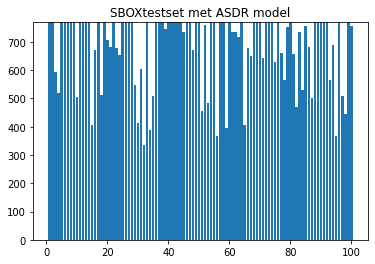

De errors zijn (afgerond tot gehele waarden):
[521, 503, 486, 502, 473, 471, 454, 458, 478, 473, 528, 472, 486, 495, 466, 439, 527, 468, 504, 476, 503, 533, 507, 531, 465, 473, 525, 457, 451, 463, 444, 499, 475, 485, 483, 512, 491, 461, 487, 529, 507, 476, 476, 523, 481, 506, 499, 470, 467, 506, 464, 511, 467, 480, 474, 505, 489, 499, 520, 463, 465, 471, 451, 467, 472, 473, 488, 521, 462, 509, 514, 500, 473, 483, 466, 506, 462, 499, 464, 475, 534, 461, 480, 474, 495, 472, 455, 487, 518, 474, 479, 498, 487, 514, 520, 491, 478, 473, 497, 511]
De predicties zijn:
[76.04537200927734, 103.04003143310547, 66.26778411865234, 97.07769012451172, 86.32201385498047, 89.43220520019531, 108.77935028076172, 84.60456085205078, 82.4906997680664, 68.56613159179688, 82.64852142333984, 95.86885070800781, 84.50782012939453, 78.88687896728516, 91.1082534790039, 103.43041229248047, 79.73011016845703, 79.12924194335938, 83.10620880126953, 100.41828155517578, 86.3418960571289, 65.96016693115234, 100.888381958

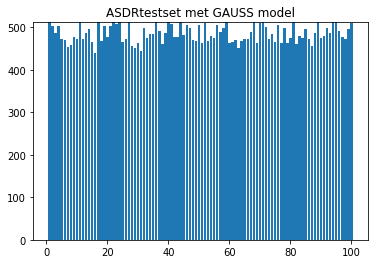

De errors zijn (afgerond tot gehele waarden):
[356, 298, 359, 376, 298, 289, 317, 304, 337, 395, 323, 322, 306, 303, 407, 409, 319, 395, 318, 345, 371, 294, 358, 352, 346, 291, 318, 342, 420, 398, 351, 386, 293, 420, 392, 310, 342, 328, 343, 343, 324, 353, 340, 326, 357, 352, 332, 365, 342, 355, 394, 361, 412, 300, 335, 395, 290, 328, 379, 348, 362, 353, 349, 322, 406, 353, 360, 349, 322, 335, 387, 335, 322, 331, 372, 340, 358, 377, 347, 358, 385, 404, 379, 375, 357, 372, 389, 341, 325, 373, 326, 363, 370, 365, 401, 359, 385, 395, 349, 356]
De predicties zijn:
[227.45057678222656, 246.72628784179688, 227.3599090576172, 171.7171173095703, 262.47662353515625, 260.1726989746094, 255.61126708984375, 252.37391662597656, 220.66529846191406, 187.87062072753906, 263.01239013671875, 265.0467834472656, 251.7365264892578, 264.36968994140625, 183.7664031982422, 187.0381622314453, 223.29148864746094, 180.16839599609375, 239.87503051757812, 204.4781494140625, 237.2364959716797, 258.0678405761719, 19

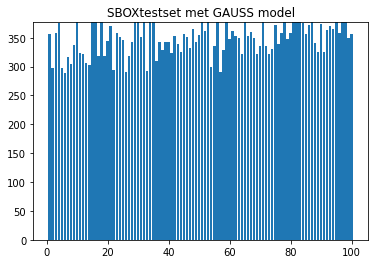

De errors zijn (afgerond tot gehele waarden):
[470, 322, 288, 262, 515, 297, 525, 233, 536, 287, 358, 492, 340, 429, 521, 226, 355, 260, 556, 243, 265, 422, 503, 576, 271, 258, 596, 263, 431, 265, 228, 353, 266, 514, 284, 325, 544, 518, 257, 575, 542, 380, 517, 563, 238, 565, 317, 258, 266, 327, 510, 281, 520, 301, 254, 529, 517, 405, 580, 234, 303, 237, 487, 330, 386, 262, 286, 394, 289, 270, 351, 211, 405, 373, 204, 529, 264, 431, 201, 285, 404, 453, 532, 300, 326, 227, 423, 297, 341, 287, 445, 299, 523, 562, 573, 507, 217, 431, 426, 286]
De predicties zijn:
[126.94112396240234, 284.2764587402344, 263.9755554199219, 336.5371398925781, 44.3828010559082, 263.4814758300781, 37.90446472167969, 310.31500244140625, 23.893983840942383, 254.7509307861328, 252.9252166748047, 75.94575500488281, 230.70191955566406, 144.85191345214844, 35.743675231933594, 316.2117614746094, 252.37501525878906, 286.5558776855469, 30.95643424987793, 333.0375061035156, 323.8418884277344, 177.28578186035156, 105.056

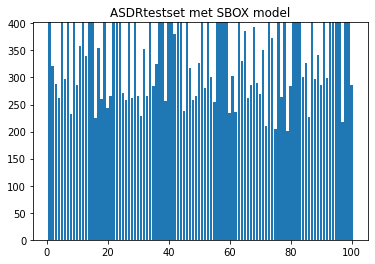

De errors zijn (afgerond tot gehele waarden):
[358, 1000, 1733, 146, 487, 579, 1551, 667, 170, 234, 366, 724, 1337, 1776, 386, 466, 158, 1228, 1129, 911, 1724, 1545, 1461, 366, 571, 2519, 674, 460, 1717, 2096, 942, 338, 1469, 359, 107, 998, 410, 1663, 1415, 405, 2878, 256, 173, 409, 1658, 1596, 1054, 169, 4947, 426, 1588, 254, 1388, 357, 576, 812, 1339, 391, 2656, 1754, 1547, 937, 682, 444, 1742, 2194, 394, 425, 2481, 375, 692, 69, 2696, 153, 324, 1722, 2402, 1629, 418, 1524, 1942, 1307, 382, 2831, 2322, 249, 1501, 711, 106, 391, 894, 366, 631, 334, 1121, 1989, 1098, 834, 1444, 518]
De predicties zijn:
[194.1995086669922, 1588.7591552734375, 2286.251953125, 458.2922668457031, 1041.436767578125, 1135.4912109375, 2147.53466796875, 1220.6602783203125, 441.006103515625, 352.3326110839844, 945.180908203125, 1299.00537109375, 1925.5504150390625, 2380.79736328125, 218.9960479736328, 121.5487289428711, 428.83026123046875, 1775.81396484375, 1683.8770751953125, 1519.857177734375, 2328.2075195312

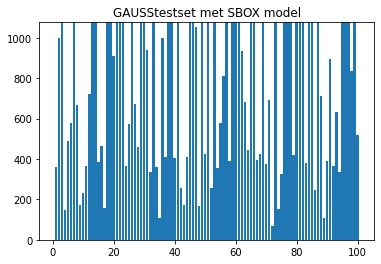

In [ ]:
plotpredictieerrors(predictionslistGAUSS_ASDRflat, delaypiekGAUSStest, "GAUSStestset met ASDR model")
plotpredictieerrors(predictionslistSBOX_ASDRflat, delaypiekSBOXtest, "SBOXtestset met ASDR model")
plotpredictieerrors(predictionslistASDR_GAUSSflat, delaypiekASDRtest, "ASDRtestset met GAUSS model")
plotpredictieerrors(predictionslistSBOX_GAUSSflat, delaypiekSBOXtest, "SBOXtestset met GAUSS model")
plotpredictieerrors(predictionslistASDR_SBOXflat, delaypiekASDRtest, "ASDRtestset met SBOX model")
plotpredictieerrors(predictionslistGAUSS_SBOXflat, delaypiekGAUSStest, "GAUSStestset met SBOX model")